# Diffusion 在1D/2D的例子

## 加载数据集

In [1]:
import torch
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

notebook_dir = os.path.dirname(os.path.abspath("__file__"))
ibc_parent_dir = os.path.abspath(os.path.join(notebook_dir, ".."))
sys.path.append(ibc_parent_dir)

from tqdm.auto import tqdm
import dataset_2d

/home/junbo/anaconda3/envs/robodiff/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
experiment_name = "dp_step_30" # custom experiment name
custom_seed = 42 # custom seed

train_dataset_size = 30 # custom dataset size
train_batch_size = 8
trian_num_workers = 1

test_dataset_size = 500
test_batch_size = 8
test_num_workers = 1

In [3]:
train_dataset_config = dataset_2d.ToyDatasetConfig(
    dataset_size=train_dataset_size,
    seed=custom_seed,
    mode = 'step',    
)
train_dataset = dataset_2d.Toy1DDataset(train_dataset_config)  # data: coordinate regression shape:（N,2)
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True,
    num_workers=trian_num_workers,
    pin_memory=torch.cuda.is_available(),
)

# Test split.
test_dataset_config = dataset_2d.ToyDatasetConfig(
    dataset_size=test_dataset_size,
    seed=custom_seed, 
    mode = 'step',
)
test_dataset = dataset_2d.Toy1DDataset(test_dataset_config)
test_dataset.exclude(train_dataset.coordinates) # 防止测试集中包含训练集的数据
test_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False,
    num_workers=test_num_workers,
    pin_memory=torch.cuda.is_available(),
)

Resampled 30 data points.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


batch的类型: <class 'list'>
batch包含的元素数量: 2
batch[0].shape:torch.Size([8, 1])
batch[1].shape:torch.Size([8, 1])
x = torch.Size([1])
y = torch.Size([1])


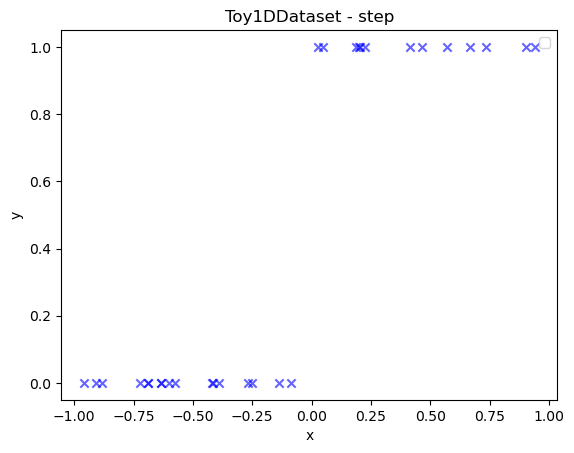

In [4]:
batch = next(iter(train_dataloader))    # 可以更改为test_dataloader查看测试集的shape

print("batch的类型:", type(batch))  # data + label
print("batch包含的元素数量:", len(batch))

for i in range(len(batch)):
    print("batch[{}].shape:{}".format(i, batch[i].shape))

# Visualize one instance.
x, y = train_dataset[np.random.randint(len(train_dataset))]
print("x =", x.shape)
print("y =", y.shape)

xs = train_dataset.coordinates.flatten()
ys = train_dataset.targets  # shape (N, 3) for circle_with_line

plt.figure()

if ys.ndim == 1 or ys.shape[1] == 1:
    # 普通 1D 情况
    plt.scatter(xs, ys.flatten(), marker="x", c="blue", alpha=0.6)

else:
    # 分别绘制 line / upper_arc / lower_arc
    plt.scatter(xs, ys[:, 0], marker="x", c="black", alpha=0.6, label="line")
    plt.scatter(xs, ys[:, 1], marker="o", c="blue", alpha=0.6, label="upper arc")
    plt.scatter(xs, ys[:, 2], marker="o", c="green", alpha=0.6, label="lower arc")

plt.title(f"Toy1DDataset - {train_dataset.mode}")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


batch的类型: <class 'list'>
batch包含的元素数量: 2
batch[0].shape:torch.Size([8, 1])
batch[1].shape:torch.Size([8, 1])
x = torch.Size([1])
y = torch.Size([1])
x = tensor([0.8661])
y = tensor([1.])


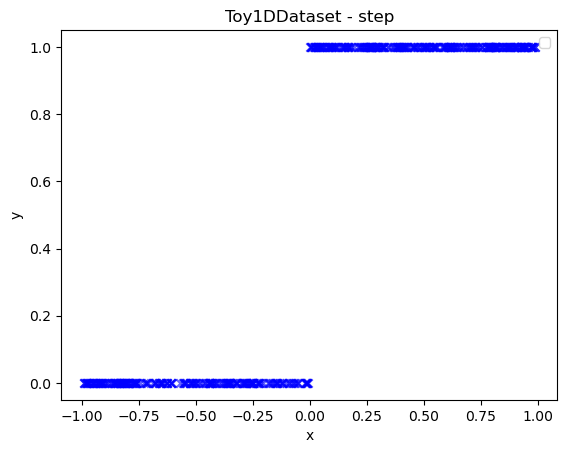

In [5]:
batch = next(iter(test_dataloader)) 

print("batch的类型:", type(batch))  # data + label
print("batch包含的元素数量:", len(batch))

for i in range(len(batch)):
    print("batch[{}].shape:{}".format(i, batch[i].shape))

x, y = test_dataset[np.random.randint(len(train_dataset))]
print("x =", x.shape)
print("y =", y.shape)
print("x =", x)
print("y =", y)

xs = test_dataset.coordinates.flatten()
ys = test_dataset.targets  # shape (N, 3) for circle_with_line

plt.figure()

if ys.ndim == 1 or ys.shape[1] == 1:
    # 普通 1D 情况
    plt.scatter(xs, ys.flatten(), marker="x", c="blue", alpha=0.6)

else:
    # 分别绘制 line / upper_arc / lower_arc
    plt.scatter(xs, ys[:, 0], marker="x", c="black", alpha=0.6, label="line")
    plt.scatter(xs, ys[:, 1], marker="o", c="blue", alpha=0.6, label="upper arc")
    plt.scatter(xs, ys[:, 2], marker="o", c="green", alpha=0.6, label="lower arc")

plt.title(f"Toy1DDataset - {train_dataset.mode}")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()


## 搭建网络

需要前向扩散，逆向扩散过程

噪声调度